# Biomedical Image Segmentation with U-Net

## Demonstration objectives
* **MKL-DNN** library in action
* U-Net based segmentation on edge hardware
* Healthcare applications of OpenVINO™

In this code example, we apply the U-Net architecture to segment brain tumors from raw MRI scans as shown below. With relatively little data we are able to train a U-Net model to accurately predict where tumors exist. 

The Dice coefficient (the standard metric for the BraTS dataset used in the study) for our model is about 0.82-0.88.  Menze et al. [reported](http://ieeexplore.ieee.org/document/6975210/) that expert neuroradiologists manually segmented these tumors with a cross-rater Dice score of 0.75-0.85, meaning that the model’s predictions are on par with what expert physicians have made.

<img src="images/figure1.png">

Since its introduction two years ago, the [U-Net](https://arxiv.org/pdf/1505.04597.pdf0) architecture has been used to create deep learning models for segmenting [nerves](https://github.com/jocicmarko/ultrasound-nerve-segmentation) in ultrasound images, [lungs](https://www.kaggle.com/c/data-science-bowl-2017#tutorial) in CT scans, and even [interference](https://github.com/jakeret/tf_unet) in radio telescopes.

## What is U-Net?
U-Net is designed like an [auto-encoder](https://en.wikipedia.org/wiki/Autoencoder). It has an encoding path (“contracting”) paired with a decoding path (“expanding”) which gives it the “U” shape.  However, in contrast to the autoencoder, U-Net predicts a pixelwise segmentation map of the input image rather than classifying the input image as a whole. For each pixel in the original image, it asks the question: “To which class does this pixel belong?” This flexibility allows U-Net to predict different parts of the tumor simultaneously.

<img src="images/unet.png">

## Step 0: Set Up

### 0.1: Import dependencies

Run the below cells to import dependencies (select the cell and use **Ctrl+enter** to run the cell). 

In [16]:
import sys, os 
import ipywidgets as widgets
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent.parent))
from demoTools.demoutils import *
from IPython.display import display

Here we configure MKL-DNN, an OpenVINO™ library that utilizes the full power of Intel® processors. We will setup up both a **stock (MKL-disabled)** and **optimized (MKL-enabled)** version of TensorFlow and the associated conda environments to compare their performance. Note that these steps may take a few minutes as we will be installing packages locally to your computer.

In [2]:
#Check if conda env with stock tensorflow already exists
stocktf_exist = !/glob/supplementary-software/versions/Miniconda/miniconda3/condabin/conda info --envs | grep "stocktf "
if not stocktf_exist:
    print("Create stocktf conda environment")
    !/glob/supplementary-software/versions/Miniconda/miniconda3/condabin/conda config --set auto_activate_base false
    !/glob/supplementary-software/versions/Miniconda/miniconda3/condabin/conda env create -f "stocktf.yml"
else:
    print("stocktf conda environment exists")

Create stocktf conda environment
Solving environment: done

ipython_genutils-0.2 | 39 KB     | ##################################### | 100% 
pip-19.0.3           | 1.9 MB    | ##################################### | 100% 
libstdcxx-ng-8.2.0   | 2.9 MB    | ##################################### | 100% 
pyrsistent-0.14.11   | 90 KB     | ##################################### | 100% 
certifi-2019.3.9     | 155 KB    | ##################################### | 100% 
pygments-2.3.1       | 1.4 MB    | ##################################### | 100% 
bleach-3.1.0         | 226 KB    | ##################################### | 100% 
nbconvert-5.4.1      | 423 KB    | ##################################### | 100% 
hdf5-1.10.4          | 5.3 MB    | ##################################### | 100% 
entrypoints-0.3      | 12 KB     | ##################################### | 100% 
ptyprocess-0.6.0     | 23 KB     | ##################################### | 100% 
setuptools-40.8.0    | 647 KB    | ##############

In [3]:
%%writefile healthcare_job_stocktf.sh

cd $PBS_O_WORKDIR 
# Running the code inside stocktf conda env
SAMPLEPATH=$PBS_O_WORKDIR
export PATH=/glob/supplementary-software/versions/Miniconda/miniconda3/condabin:$PATH
source /glob/supplementary-software/versions/Miniconda/miniconda3/etc/profile.d/conda.sh
conda activate stocktf
python3 healthcare_no_openvino.py -r $1
conda deactivate

Writing healthcare_job_stocktf.sh


In [4]:
#Check if conda env with optimized tensorflow using mkl already exists
mkltf_exist = !/glob/supplementary-software/versions/Miniconda/miniconda3/condabin/conda info --envs | grep "mkltf "
if not mkltf_exist:
    print("Create mkltf conda environment")
    !/glob/supplementary-software/versions/Miniconda/miniconda3/condabin/conda config --set auto_activate_base false
    !/glob/supplementary-software/versions/Miniconda/miniconda3/condabin/conda env create -f "mkltf.yml"
else:
    print("mkltf conda environment exists")

Create mkltf conda environment
Solving environment: done

libtool-2.4.6        | 512 KB    | ##################################### | 100% 
pydotplus-2.0.2      | 42 KB     | ##################################### | 100% 
qt-5.6.2             | 44.6 MB   | ##################################### | 100% 
libopenblas-0.2.20   | 8.8 MB    | ##################################### | 100% 
tensorflow-base-1.12 | 98.5 MB   | ##################################### | 100% 
liblapack-3.8.0      | 6 KB      | ##################################### | 100% 
setuptools-40.8.0    | 626 KB    | ##################################### | 100% 
libiconv-1.15        | 2.0 MB    | ##################################### | 100% 
python-3.6.6         | 29.0 MB   | ##################################### | 100% 
grpcio-1.16.0        | 1.0 MB    | ##################################### | 100% 
xorg-libxrender-0.9. | 31 KB     | ##################################### | 100% 
giflib-5.1.9         | 108 KB    | ################

## Step 1. Load the MKL-DNN Model
We will load the MKL-DNN model into our virtual conda environment by running a Python file.   

In [5]:
%%writefile healthcare_job_mkltf.sh

cd $PBS_O_WORKDIR 
# Running the code inside mkltf conda env
SAMPLEPATH=$PBS_O_WORKDIR
export PATH=/glob/supplementary-software/versions/Miniconda/miniconda3/condabin:$PATH
source /glob/supplementary-software/versions/Miniconda/miniconda3/etc/profile.d/conda.sh
conda activate mkltf
python3 healthcare_no_openvino.py -r $1 
conda deactivate

Writing healthcare_job_mkltf.sh


## Step 2. Inference Time!
Here we create job files and submit them to different edge compute nodes. They will go into a queue and run once the compute resources are available. 

#### Submitting to an edge compute node with an Intel® CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core™ i5-6500TE processor</a>. The inference workload will run the CPU inside stocktf conda environment.

In [6]:
core_stocktf = !qsub healthcare_job_stocktf.sh -l nodes=1:tank-870:i5-6500te  -F "results/"
print(core_stocktf[0]) 
if core_stocktf:
    progressIndicator('results/'+core_stocktf[0], 'i_progress.txt', "Processing", 0, 100)

25369.c003


#### Submitting to an edge compute node with Intel® Xeon® CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88178/Intel-Xeon-Processor-E3-1268L-v5-8M-Cache-2-40-GHz-">Intel® 
    Xeon® Processor E3-1268L v5</a>. The inference workload will run on the CPU inside stocktf conda environment.

In [7]:
#Submit job to the queue
xeon_stocktf = !qsub healthcare_job_stocktf.sh -l nodes=1:tank-870:e3-1268l-v5 -F "results/"
print(xeon_stocktf[0]) 
if xeon_stocktf:
    progressIndicator('results/'+xeon_stocktf[0], 'i_progress.txt', "Processing", 0, 100)

25370.c003


#### Submitting to an edge compute node with an Intel® CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core™ i5-6500TE processor</a>. The inference workload will run the CPU inside mkltf conda environment.

In [8]:
core_mkltf = !qsub healthcare_job_mkltf.sh -l nodes=1:tank-870:i5-6500te  -F "results/"
print(core_mkltf[0]) 
if core_mkltf:
    progressIndicator('results/'+core_mkltf[0], 'i_progress.txt', "Processing", 0, 100)

25371.c003


#### Submitting to an edge compute node with Intel® Xeon® CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88178/Intel-Xeon-Processor-E3-1268L-v5-8M-Cache-2-40-GHz-">Intel® 
    Xeon® Processor E3-1268L v5</a>. The inference workload will run on the CPU inside mkltf conda environment.

In [9]:
#Submit job to the queue
xeon_mkltf = !qsub healthcare_job_mkltf.sh -l nodes=1:tank-870:e3-1268l-v5  -F "results/"
print(xeon_mkltf[0]) 
if xeon_mkltf:
    progressIndicator('results/'+xeon_mkltf[0], 'i_progress.txt', "Processing", 0, 100)

25372.c003


In [10]:
liveQstat()

Output(layout=Layout(border='1px solid gray', width='100%'))

Button(description='Stop', style=ButtonStyle())

## Step 3. Results
### 3.1: Image Comparison
Here, we visualize our predictions. We can observe the frame rate, execution time, and dice coefficient (a value that describes the similarity between the ground truth and the prediction, with 1.0 indicating 100% accuracy). 

In [17]:
outputHTML('IEI Tank (Intel Core CPU)',
          'results/'+core_stocktf[0], '.png')

In [12]:
outputHTML('IEI Tank Xeon (Intel Xeon CPU)',
          'results/'+xeon_stocktf[0], '.png')

In [13]:
outputHTML('IEI Tank (Intel Core CPU)',
          'results/'+core_mkltf[0], '.png')

In [14]:
outputHTML('IEI Tank Xeon (Intel Xeon CPU)',
          'results/'+xeon_mkltf[0], '.png')

### 3.2: Architecture Comparison
Finally, we benchmark the processing time and frames per second on different architectures with and without MKL-DNN.

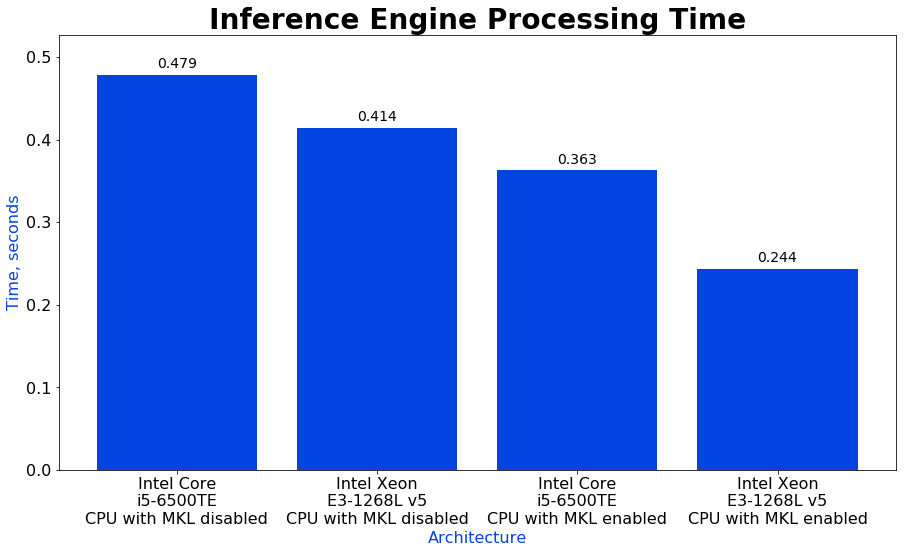

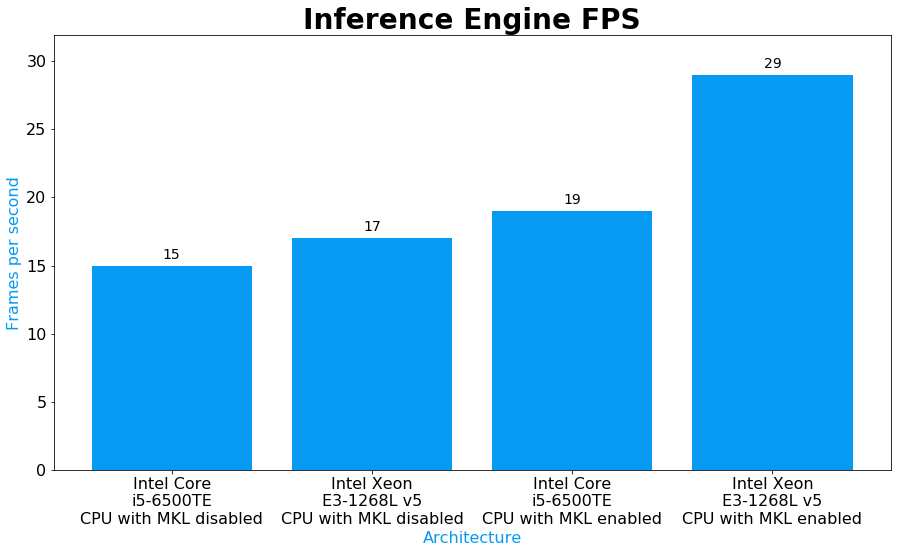

In [18]:
arch_list = [('core_stocktf', 'Intel Core\ni5-6500TE\nCPU with MKL disabled'),
             ('xeon_stocktf', 'Intel Xeon\nE3-1268L v5\nCPU with MKL disabled'),
             ('core_mkltf', 'Intel Core\ni5-6500TE\nCPU with MKL enabled'),
             ('xeon_mkltf', 'Intel Xeon\nE3-1268L v5\nCPU with MKL enabled')
             ]

stats_list = []
for job, a_name in arch_list:
    if job in vars():
        stats_list.append(('results/'+vars()[job][0]+'/stats.txt', a_name))
    else:
        stats_list.append(('placeholder'+job, a_name))

summaryPlot(stats_list, 'Architecture', 'Time, seconds', 'Inference Engine Processing Time', 'time' )

summaryPlot(stats_list, 'Architecture', 'Frames per second', 'Inference Engine FPS', 'fps' )